# Language Translator 
By Akshit Singh

### Sequence-to-sequence learning

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Embedding
from tensorflow.keras.layers import Dense,MultiHeadAttention,LayerNormalization,Embedding,Dropout,Layer
from tensorflow.keras import Sequential,Input
from tensorflow.keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import sentence_bleu

In [2]:
# text_file = keras.utils.get_file(
#     fname="fra-eng.zip",
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
#     extract=True,
# )
# print(text_file)
# text_file = pathlib.Path(text_file).parent / "fra.txt"
text_file = '/kaggle/input/french/fra.txt'

Each line contains an English sentence and its corresponding France sentence. The English sentence is the source sequence and France one is the target sequence. We prepend the token "[start]" and we append the token "[end]" to the France sentence.

In [3]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, french = line.split("\t")
    french = "[start] " + french + " [end]"
    text_pairs.append((english, french))

### Printing random English - French text pair

In [4]:
import random
print(random.choice(text_pairs))

('When we entered the shack, we saw a half-eaten pie on the table.', '[start] En entrant dans la cabane, nous vîmes une tarte à moitié mangée sur la table. [end]')


In [5]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Text Cleaning**

In [6]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

**Text Standardization**
* Convert Text to lowercase

In [7]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [8]:
vocab_size = 15000
sequence_length = 20

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_french_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_french_texts)

In [9]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.TPUStrategy(tpu)
# # batch_size
# batch_size = 8 * tpu_strategy.num_replicas_in_sync

In [10]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available: ", gpus)

if len(gpus) > 1:
    print(f"Number of GPUs: {len(gpus)}")
else:
    print("Less than 2 GPUs detected.")

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Number of GPUs: 2


In [11]:
strategy = tf.distribute.MirroredStrategy()

print("Number of devices in strategy:", strategy.num_replicas_in_sync)


Number of devices in strategy: 2


In [12]:
batch_size = 64

In [13]:
print(f"Batch size: {batch_size}")

Batch size: 64


**Preparing datasets for the translation task**

In [14]:


def format_dataset(eng, fre):
    eng = source_vectorization(eng)
    fre = target_vectorization(fre)
    return ({
        "english": eng,
        "french": fre[:, :-1],
    }, fre[:, 1:])

def make_dataset(pairs):
    eng_texts, fre_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fre_texts = list(fre_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fre_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [15]:
train_ds

<CacheDataset shapes: ({english: (None, 20), french: (None, 20)}, (None, 20)), types: ({english: tf.int64, french: tf.int64}, tf.int64)>

In [16]:
for inputs, targets in train_ds.take(1):
    print(f"english {inputs['english']},\n\n\n inputs['english'].shape: {inputs['english'].shape}")
    print(f"french {inputs['french']},\n\n\n inputs['french'].shape: {inputs['french'].shape}")
    print(f"targets {targets}, \n\n\n targets.shape: {targets.shape}")

english [[ 138 2163   37 ...    0    0    0]
 [  10   91   28 ...    0    0    0]
 [   7  425 1429 ...    0    0    0]
 ...
 [   5  318  905 ...    0    0    0]
 [ 209  206    4 ...    0    0    0]
 [ 539   20  110 ...    0    0    0]],


 inputs['english'].shape: (64, 20)
french [[    2    85     5 ...     0     0     0]
 [    2    13   123 ...     0     0     0]
 [    2 14761  3569 ...     0     0     0]
 ...
 [    2    13    49 ...     0     0     0]
 [    2    13   153 ...     0     0     0]
 [    2    74    15 ...     0     0     0]],


 inputs['french'].shape: (64, 20)
targets [[   85     5   191 ...     0     0     0]
 [   13   123     6 ...     0     0     0]
 [14761  3569  1002 ...     0     0     0]
 ...
 [   13    49    18 ...     0     0     0]
 [   13   153    18 ...     0     0     0]
 [   74    15    38 ...     0     0     0]], 


 targets.shape: (64, 20)


### Sequence-to-sequence learning with Transformer

### A Transformer for machine translation

## Transformer Encoder

In [17]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [Dense(dense_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

#### The Transformer decoder

In [18]:
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### **Positional Embedding layer**

In [19]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=input_dim, output_dim=output_dim)
        print(input_dim,output_dim)
        #intermediate = self.getPositionEncoding(seq_len=input_dim,d=vocab_size,n=output_dim)
        self.position_embeddings = Embedding(input_dim=input_dim, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def getPositionEncoding(self,seq_len, d, n = sequence_length):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        tensor = tf.convert_to_tensor(P)
        print(tensor.shape)
        return tensor
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [20]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

with strategy.scope():

    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    
    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="french")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
    x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
    x = Dropout(0.5)(x)
    decoder_outputs = Dense(vocab_size, activation="softmax")(x)
    transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

15000 256
15000 256


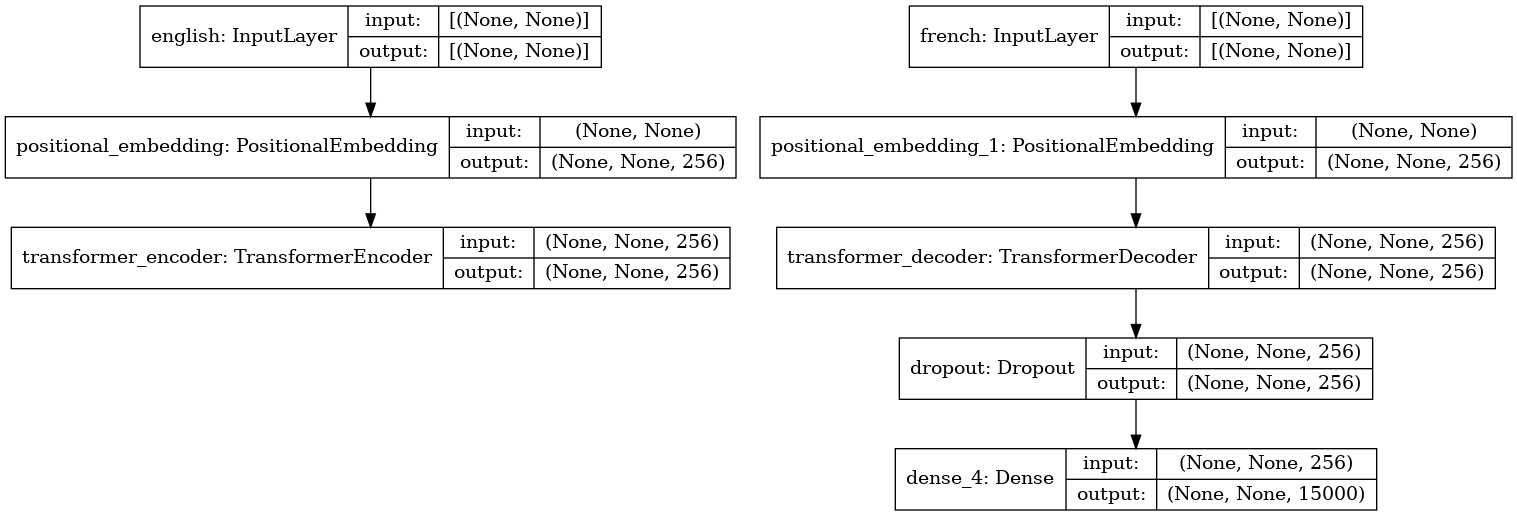

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(transformer, to_file='transformer.png', show_shapes=True)
from IPython.display import Image
Image("transformer.png")

**Training the sequence-to-sequence Transformer**

In [22]:
EPOCHS = 130

In [23]:
with strategy.scope():
    checkpoint = ModelCheckpoint(filepath='language_translation_checkpoint.hdf5',
                             save_weights_only=True,verbose=1,monitor='val_accuracy')

In [24]:
with strategy.scope():
    transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])


    transformer.fit(train_ds, epochs=EPOCHS,callbacks=[checkpoint], validation_data=val_ds)

Epoch 1/130
1828/1828 [==============================] - 105s 51ms/step - loss: 1.5631 - accuracy: 0.4739 - val_loss: 1.1993 - val_accuracy: 0.5675

Epoch 00001: saving model to language_translation_checkpoint.hdf5
Epoch 2/130
1828/1828 [==============================] - 93s 51ms/step - loss: 1.2234 - accuracy: 0.5817 - val_loss: 1.0604 - val_accuracy: 0.6157

Epoch 00002: saving model to language_translation_checkpoint.hdf5
Epoch 3/130
1828/1828 [==============================] - 93s 51ms/step - loss: 1.0947 - accuracy: 0.6219 - val_loss: 1.0128 - val_accuracy: 0.6397

Epoch 00003: saving model to language_translation_checkpoint.hdf5
Epoch 4/130
1828/1828 [==============================] - 93s 51ms/step - loss: 1.0397 - accuracy: 0.6457 - val_loss: 0.9860 - val_accuracy: 0.6537

Epoch 00004: saving model to language_translation_checkpoint.hdf5
Epoch 5/130
1828/1828 [==============================] - 93s 51ms/step - loss: 1.0101 - accuracy: 0.6623 - val_loss: 0.9725 - val_accuracy: 0.6

In [25]:
# saving model achitecture in json file
model_json = transformer.to_json()
with open("translator.json", "w") as json_file:
    json_file.write(model_json)

**Translating new sentences with our Transformer model**

In [26]:
fra_vocab = target_vectorization.get_vocabulary()
fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))
max_decoded_sentence_length = 20

### Output Testing and Decoding the output sequence

In [27]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fra_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

### Transformer translating output

In [28]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Can I touch it?
[start] puisje y [UNK] [end]
-
They have everything they need.
[start] ils ont tout ce quils ont besoin [end]
-
Please put the chair away. It is in the way.
[start] mets la chaise sur la chaise sil te plait [end]
-
If I knew how to use a computer, maybe they would pay me more.
[start] si je savais comme utiliser un ordinateur il se [UNK] peutêtre de davantage [end]
-
I brought dinner.
[start] jai amené un dîner [end]


# Evaluation using the BLEU score

In [29]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
score = 0
bleu  = 0
for i in range(20):
    candidate = decode_sequence(test_eng_texts[i])
    reference = test_fra_texts[i].lower()
    print(candidate,reference)
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu+=score
    print(f"Score:{score}")
print(f"\nBLEU score : {round(bleu,2)}/20")
    

[start] ils ont juste [UNK] [end] [start] ils viennent de partir. [end]
Score:0.36363636363636365


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

[start] nous y sommes arrivée avant midi [end] [start] nous y arrivâmes avant midi. [end]
Score:0.3478260869565218
[start] vous êtes très [UNK] [end] [start] tu es fort avisée. [end]
Score:0.38235294117647056
[start] elle a dit au revoir [end] [start] elle a dit "au revoir". [end]
Score:0.4411764705882353
[start] il a fait ce quil a promis [end] [start] il fit ce qu'il promit de faire pour moi. [end]
Score:0.475
[start] jai fait ce que je crois [end] [start] j'ai fait ce qui me semblait être juste. [end]
Score:0.42105263157894735
[start] le président [UNK] [end] [start] le président a aboli l'esclavage. [end]
Score:0.4375
[start] vous vous vous vous vous vous vous vous plaindre [end] [start] tu te sentiras mieux dans quelques heures. [end]
Score:0.20967741935483875
[start] sa maison est au pied de la montagne [end] [start] sa maison est au pied d'une montagne. [end]
Score:0.32
[start] je navais pas de mal [end] [start] je ne pensais pas à mal. [end]
Score:0.4411764705882353
[start] soy

## Summary

* Thus Transformer model is implemented for translating English to france.
* BLEU score is the metrics used to evaluate the performance of the tranformer in translating the language.